---

####  **<ins> Name: Muhammad Faizan Akram </ins>**  
#### **<ins> Registration No: FA23-BBD-090 (5A)</ins>**
#### **<ins> Project: Buy Now Pay Later Default Risk Prediction  </ins>**

---

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

---

#### **Variables:** 
- **customer_id** = unique ID
- **age** = customer age
- **monthly_income** = income in PKR
- **employment_status** = Salaried / Self-Employed / Unemployed
- **purchase_amount** = BNPL purchase value
- **installments** = 3, 6, 9, or 12
- **previous_bnpl_loans** = historical BNPL usage
- **avg_overdue_days** = average payment delay
- **missed_payments** = count of missed installments
- **default** = target variable (1 = default, 0 = no default)

---

In [205]:
df = pd.read_csv('data.csv')
df.sample(10)

,customer_id,age,monthly_income,employment_status,purchase_amount,installments,previous_bnpl_loans,avg_overdue_days,missed_payments,default
233,234,40,99182,Salaried,25091,12,0,36,2,0
101,102,25,27079,Salaried,87716,3,4,8,1,1
910,911,32,128409,Salaried,120333,6,3,22,1,1
177,178,29,48236,Salaried,78240,6,2,5,2,0
799,800,43,70893,Salaried,45937,6,3,28,2,1
349,350,30,69547,Salaried,120474,12,0,24,3,1
455,456,50,50931,Salaried,15050,6,0,20,1,0
275,276,50,108559,Self-Employed,75402,12,7,36,3,1
592,593,50,195286,Self-Employed,14360,6,1,17,1,0
808,809,42,86367,Unemployed,63510,6,5,30,0,1


---

##### There are 1000 rows and 10 columns.

In [206]:
df.shape

(1000, 10)

---

##### Customer_id is useless for model fitting. So, we will drop it.

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_id          1000 non-null   int64 
 1   age                  1000 non-null   int64 
 2   monthly_income       1000 non-null   int64 
 3   employment_status    1000 non-null   object
 4   purchase_amount      1000 non-null   int64 
 5   installments         1000 non-null   int64 
 6   previous_bnpl_loans  1000 non-null   int64 
 7   avg_overdue_days     1000 non-null   int64 
 8   missed_payments      1000 non-null   int64 
 9   default              1000 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 78.3+ KB


In [208]:
df = df.drop('customer_id', axis=1)

---

##### There is no missing and duplicated values in this dataset.

In [209]:
df.isnull().sum()

age                    0
monthly_income         0
employment_status      0
purchase_amount        0
installments           0
previous_bnpl_loans    0
avg_overdue_days       0
missed_payments        0
default                0
dtype: int64

In [210]:
df.duplicated().sum()

np.int64(0)

---

##### There are 47.4% people out of 100% who got default.

In [211]:
df["default"].value_counts(normalize=True)

default
0    0.526
1    0.474
Name: proportion, dtype: float64

---

##### We will apply basic statistics on numerical variables.

In [212]:
num_cols = ["age","monthly_income","purchase_amount","previous_bnpl_loans","avg_overdue_days","missed_payments"]
df[num_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,1000.0,38.74,12.19,18.0,28.00,40.0,50.00,59.0
monthly_income,1000.0,115719.59,50690.16,25126.0,71585.50,115362.0,159471.25,199668.0
purchase_amount,1000.0,75747.26,42836.43,2159.0,37908.75,76654.0,112484.25,149973.0
previous_bnpl_loans,1000.0,3.51,2.34,0.0,1.00,4.0,6.00,7.0
avg_overdue_days,1000.0,19.16,11.64,0.0,9.00,19.0,29.00,39.0
missed_payments,1000.0,2.43,1.70,0.0,1.00,2.0,4.00,5.0


---

##### Encoding Employment Status:

In [213]:
df["employment_status"].value_counts()

employment_status
Salaried         547
Self-Employed    360
Unemployed        93
Name: count, dtype: int64

In [214]:
df = pd.get_dummies(
    df,
    columns=["employment_status"],
    drop_first=True
)

---

##### Where self-employed and unemployed are both false, there will be a salaried person.

In [215]:
df.head()

,age,monthly_income,purchase_amount,installments,previous_bnpl_loans,avg_overdue_days,missed_payments,default,employment_status_Self-Employed,employment_status_Unemployed
0,56,151108,122356,9,6,17,0,0,False,False
1,46,39382,44727,9,6,31,0,1,True,False
2,32,109291,80471,3,3,2,1,0,False,False
3,25,126195,10068,6,6,1,2,0,False,False
4,38,159828,118923,6,4,32,0,0,True,False


---

##### Feature Engineering.

##### Feature 1: Income to purchase ratio
- Ability to afford the purchase relative to income (Can the customer afford this purchase?)
- Low ratio = higher risk.

##### Thresholds:
- ≥ 3.0 → Low risk

- 1.5 – 3.0 → Medium risk

- < 1.5 → High risk

In [216]:
df["income_purchase_ratio"] = df["monthly_income"] / df["purchase_amount"]

##### Validation through data:

In [217]:
df["income_purchase_band"] = pd.cut(df["income_purchase_ratio"], bins=[0, 1.5, 3, np.inf], labels=["High Risk", "Medium Risk", "Low Risk"])

In [218]:
df.groupby("income_purchase_band")["default"].agg(count="count", defaults="sum", default_rate="mean")

C:\Users\muham\AppData\Local\Temp\ipykernel_10432\3794274461.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("income_purchase_band")["default"].agg(count="count", defaults="sum", default_rate="mean")


,count,defaults,default_rate
income_purchase_band,,,
High Risk,473,347,0.733615
Medium Risk,278,93,0.334532
Low Risk,249,34,0.136546


##### What you expect to see?

- High Risk → highest default rate

- Medium Risk → moderate

- Low Risk → lowest

Default rate is moving like it was expected. So, thresholds are strong.

---

##### Feature 2: Installment amount
- Monthly repayment amount

In [219]:
df["installment_amount"] = df["purchase_amount"] / df["installments"]

---

##### Feature 3: Installment to income
- Monthly repayment burden compared to income

#### Thresholds:
- ≤ 0.20 (20%) → Safe

- 0.20 – 0.35 → Warning zone

- Greater than 0.35 (35%) → High risk

##### If a BNPL installment eats more than a third of income, defaults spike.

In [220]:
df["installment_to_income"] = df["installment_amount"] / df["monthly_income"]

##### Validation through data:

In [221]:
df["installment_income_band"] = pd.cut(df["installment_to_income"],bins=[0, 0.20, 0.35, np.inf],labels=["Low Risk", "Medium Risk", "High Risk"])

In [222]:
df.groupby("installment_income_band")["default"].agg(count="count",defaults="sum",default_rate="mean")

C:\Users\muham\AppData\Local\Temp\ipykernel_10432\3076051608.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("installment_income_band")["default"].agg(count="count",defaults="sum",default_rate="mean")


,count,defaults,default_rate
installment_income_band,,,
Low Risk,717,242,0.337517
Medium Risk,158,116,0.734177
High Risk,125,116,0.928000


##### This feature should show clear monotonic behavior:

- Low → Medium → High risk

- Default rate should strictly increase

- If Medium < Low → threshold needs rework.

Data is moving like it was expected. So, thresholds are strong.

---

##### Feature 4: Payment behavior score
- Combined measure of late payments and missed installments
##### Thresholds:
- ≤ 5 → Low behavioral risk

- 5 – 15 → Medium risk

- Greater than 15 → High risk

In [223]:
df["payment_risk_score"] = (
    df["avg_overdue_days"] * 0.6 +
    df["missed_payments"] * 0.4
)

##### Validation through data:

In [224]:
df["payment_risk_band"] = pd.cut(df["payment_risk_score"],bins=[-1, 5, 15, np.inf],labels=["Low Risk", "Medium Risk", "High Risk"])

In [225]:
df.groupby("payment_risk_band")["default"].agg(count="count",defaults="sum",default_rate="mean")

C:\Users\muham\AppData\Local\Temp\ipykernel_10432\2028181869.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("payment_risk_band")["default"].agg(count="count",defaults="sum",default_rate="mean")


,count,defaults,default_rate
payment_risk_band,,,
Low Risk,188,35,0.186170
Medium Risk,434,190,0.437788
High Risk,378,249,0.658730


##### Thresholds are strong.

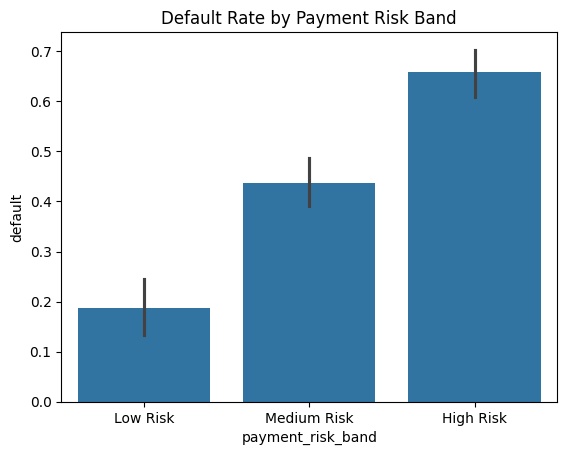

In [226]:
sns.barplot(x="payment_risk_band",y="default",data=df,estimator=np.mean)
plt.title("Default Rate by Payment Risk Band")
plt.show()

---

In [227]:
df.sample(10)

,age,monthly_income,purchase_amount,installments,previous_bnpl_loans,avg_overdue_days,missed_payments,default,employment_status_Self-Employed,employment_status_Unemployed,income_purchase_ratio,income_purchase_band,installment_amount,installment_to_income,installment_income_band,payment_risk_score,payment_risk_band
647,42,182661,125030,6,2,11,1,1,False,False,1.460937,High Risk,20838.333333,0.114082,Low Risk,7.0,Medium Risk
355,33,138824,86700,6,2,2,2,0,False,False,1.601200,Medium Risk,14450.000000,0.104089,Low Risk,2.0,Low Risk
136,40,153177,54389,9,3,17,4,0,True,False,2.816323,Medium Risk,6043.222222,0.039453,Low Risk,11.8,Medium Risk
504,42,158541,149907,9,7,12,4,1,True,False,1.057596,High Risk,16656.333333,0.105060,Low Risk,8.8,Medium Risk
22,50,158515,63388,12,0,15,1,0,True,False,2.500710,Medium Risk,5282.333333,0.033324,Low Risk,9.4,Medium Risk
930,58,157439,104638,3,0,1,0,0,False,False,1.504606,Medium Risk,34879.333333,0.221542,Medium Risk,0.6,Low Risk
849,47,165272,44215,6,0,4,3,0,True,False,3.737917,Low Risk,7369.166667,0.044588,Low Risk,3.6,Low Risk
499,49,122624,6986,3,6,19,3,0,False,False,17.552820,Low Risk,2328.666667,0.018990,Low Risk,12.6,Medium Risk
734,27,53380,136678,6,6,6,2,1,False,False,0.390553,High Risk,22779.666667,0.426745,High Risk,4.4,Low Risk
872,28,129061,135962,3,5,20,3,1,False,True,0.949243,High Risk,45320.666667,0.351157,High Risk,13.2,Medium Risk


---

##### Machine Learning:

- I selected XGBoost because the data contains non-linear relationships and engineered ratios typical of credit risk problems. XGBoost captures these patterns better than linear models while remaining interpretable using SHAP.

- But before main model, I will run logistic regression to see leakages in the model.

#### Logistic Regression:

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report
import statsmodels.api as sm 

In [234]:
X = df.drop(['default', 'income_purchase_band', 'installment_income_band', 'payment_risk_band'], axis=1)
y = df['default']

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [251]:
model = LogisticRegression()

In [252]:
model.fit(X_train, y_train)

c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [254]:
y_predict=model.predict(X_test)

In [256]:
auc = roc_auc_score(y_test, y_predict)
print("AUC:", auc)

AUC: 0.8272946859903383


In [275]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       108
           1       0.83      0.79      0.81        92

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



In [257]:
accuracy_score(y_test, y_predict)

0.83

In [259]:
import pandas as pd

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
6,missed_payments,0.162489
12,payment_risk_score,0.089991
4,previous_bnpl_loans,0.081707
5,avg_overdue_days,0.041660
8,employment_status_Unemployed,0.001628
11,installment_to_income,0.001338
2,purchase_amount,0.000045
1,monthly_income,-0.000024
10,installment_amount,-0.000070
7,employment_status_Self-Employed,-0.010126


##### X Gradient Boost Decision Tree:

In [260]:
X = df.drop(['default', 'income_purchase_band', 'installment_income_band', 'payment_risk_band'], axis=1)
y = df['default']

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Compute the imbalance ratio:
- This tells XGBoost how costly a default is relative to a non-default.

In [262]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(1.094240837696335)

In [263]:
from xgboost import XGBClassifier

In [264]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.8,
                          colsample_bytree=0.8, scale_pos_weight=scale_pos_weight, eval_metric="auc", random_state=42)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [265]:
from sklearn.metrics import roc_auc_score

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost AUC:", roc_auc_score(y_test, y_prob_xgb))

XGBoost AUC: 0.9138486312399355


In [281]:
print(confusion_matrix(y_test, xgb_model.predict(X_test)))

[[90 18]
 [18 74]]


In [287]:
print(classification_report(y_test, xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       108
           1       0.80      0.80      0.80        92

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



C:\Users\muham\AppData\Local\Temp\ipykernel_10432\1739034058.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


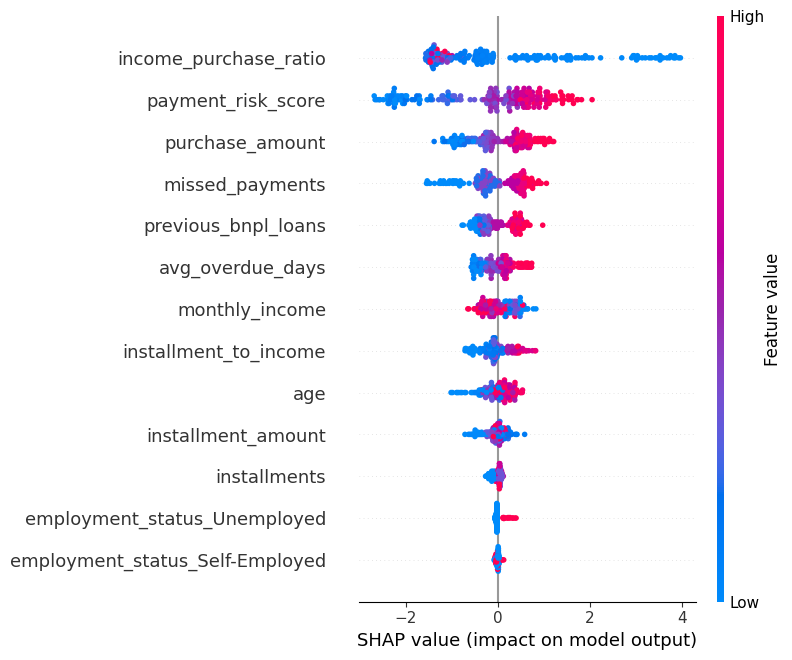

In [282]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

---

##### Cutoff Strategy:
- I selected a cutoff that maximizes recall for defaulters while maintaining reasonable precision, reflecting a conservative BNPL risk appetite

In [288]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

cutoff_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

cutoff_df.sort_values("recall", ascending=False).head()


,threshold,precision,recall
0,0.002506,0.460000,1.0
1,0.002746,0.462312,1.0
2,0.004046,0.464646,1.0
3,0.004312,0.467005,1.0
4,0.004340,0.469388,1.0


In [291]:
cutoff = 0.35

y_pred_cutoff = (y_prob_xgb >= cutoff).astype(int)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_cutoff)


array([[87, 21],
       [12, 80]])

In [293]:
import joblib

joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(X_train.columns.tolist(), "feature_names.pkl")
joblib.dump(cutoff, "cutoff.pkl")

['cutoff.pkl']